# 🧬 Analyze scFoundation Embeddings

In this notebook, we load and explore the scFoundation bulk embeddings to understand their structure, distribution, and variation before applying dimensionality reduction (PCA).


In [1]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## 📥 Load and Inspect Embeddings

Let's load the `.npy` file containing scFoundation embeddings and look at its basic properties.


In [2]:
# Load dataset
df = pd.read_parquet("../../data/processed/bulk_with_pca_tissue.parquet")

# Keep only one entry per cell line
df_unique = df.drop_duplicates(subset="SANGER_MODEL_ID")


## 📊 Basic Embedding Statistics

Let's check the distribution of embedding norms and per-dimension statistics.


In [3]:
# Select scFoundation PCA columns
feature_cols = [col for col in df_unique.columns if col.startswith("SCF_PC")]
X = df_unique[feature_cols].values


In [4]:
# Reconstruct tissue labels from one-hot encoded columns
tissue_cols = [col for col in df_unique.columns if col.startswith("Tissue_")]
df_unique["Tissue"] = df_unique[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "")


/tmp/ipykernel_303836/3659922553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["Tissue"] = df_unique[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "")


## 🌀 Optional: Visualize Embeddings with t-SNE

We'll use t-SNE to visualize global structure in 2D.


In [5]:
# Standardize features before t-SNE
X_scaled = StandardScaler().fit_transform(X)


In [6]:
# Run t-SNE on PCA features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


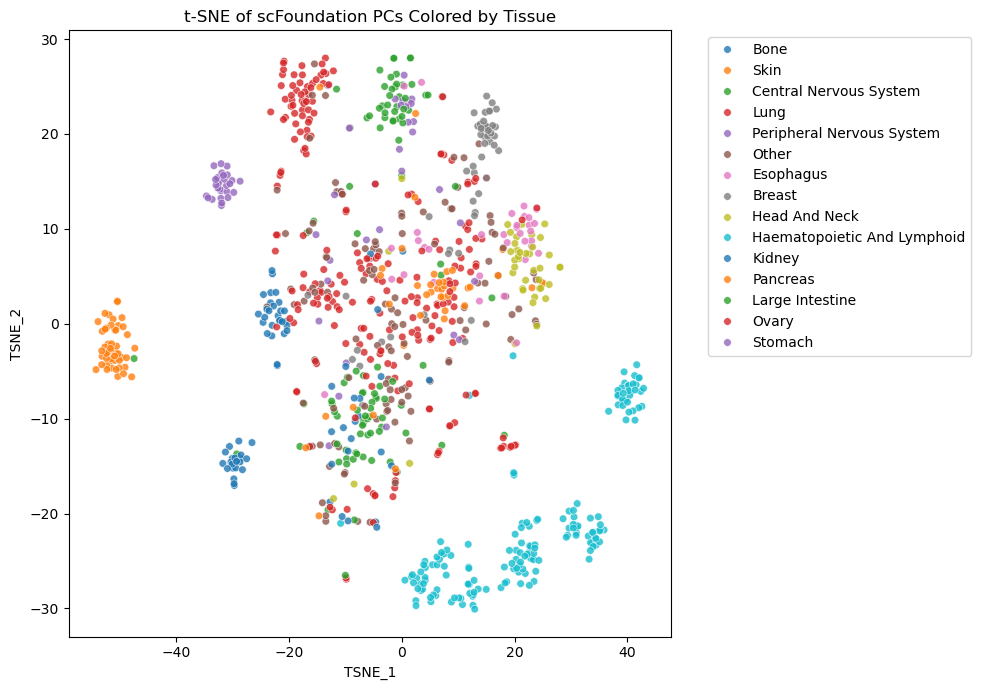

In [7]:
# Prepare DataFrame for plotting
df_plot = pd.DataFrame(X_tsne, columns=["TSNE_1", "TSNE_2"])
df_plot["Tissue"] = df_unique["Tissue"].values

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="TSNE_1", y="TSNE_2", hue="Tissue", s=30, alpha=0.8, palette="tab10")
plt.title("t-SNE of scFoundation PCs Colored by Tissue")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Define feature columns (your PCA features)
feature_cols = [col for col in df_unique.columns if col.startswith("SCF_PC")]

# Apply t-SNE
X = df_unique[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled)

# Save back to the DataFrame
df_unique["TSNE_1"] = tsne_result[:, 0]
df_unique["TSNE_2"] = tsne_result[:, 1]


/tmp/ipykernel_303836/2655129781.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["TSNE_1"] = tsne_result[:, 0]
/tmp/ipykernel_303836/2655129781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["TSNE_2"] = tsne_result[:, 1]


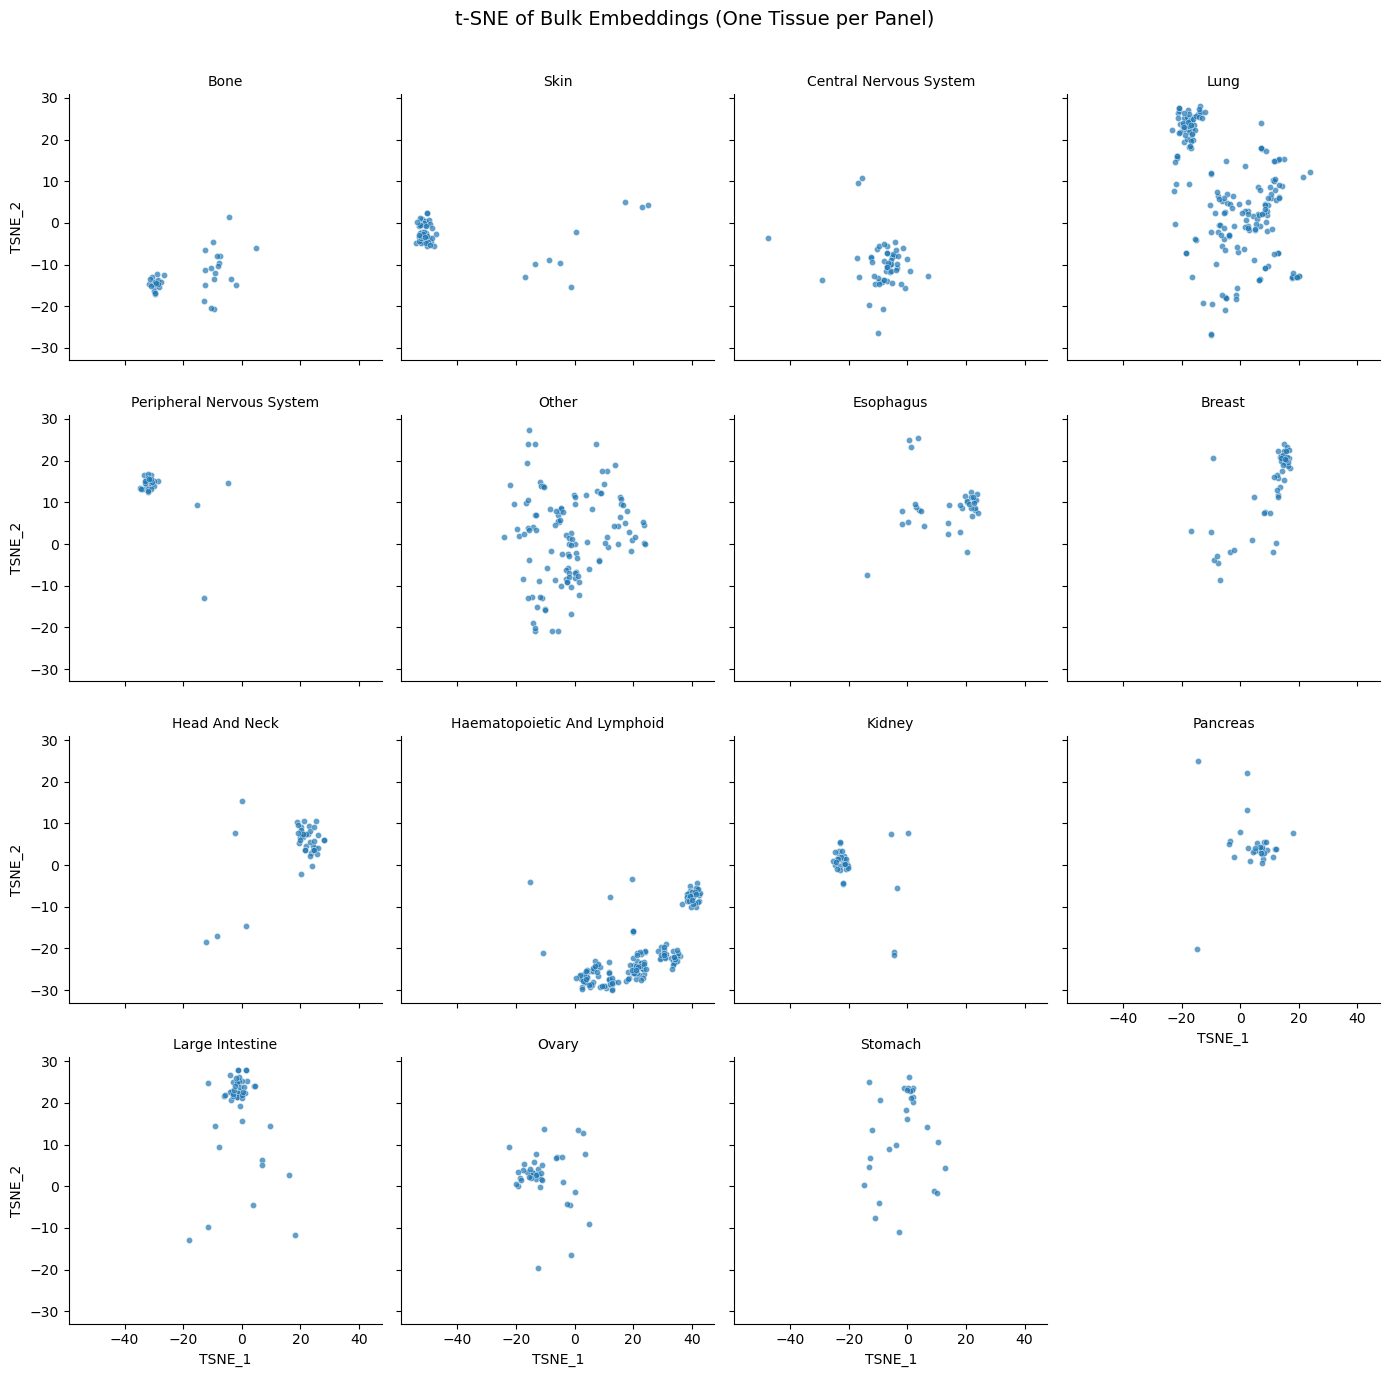

In [9]:
# Plot one tissue per panel (t-SNE faceted view)
g = sns.FacetGrid(df_unique, col="Tissue", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="TSNE_1", y="TSNE_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=10)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("t-SNE of Bulk Embeddings (One Tissue per Panel)", fontsize=14)
plt.show()


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


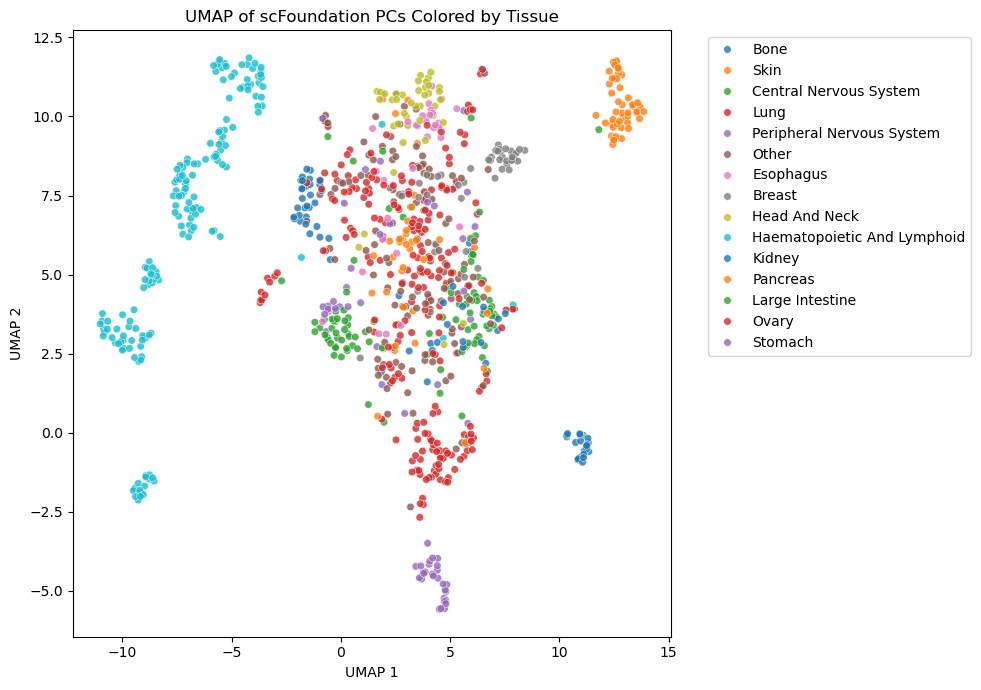

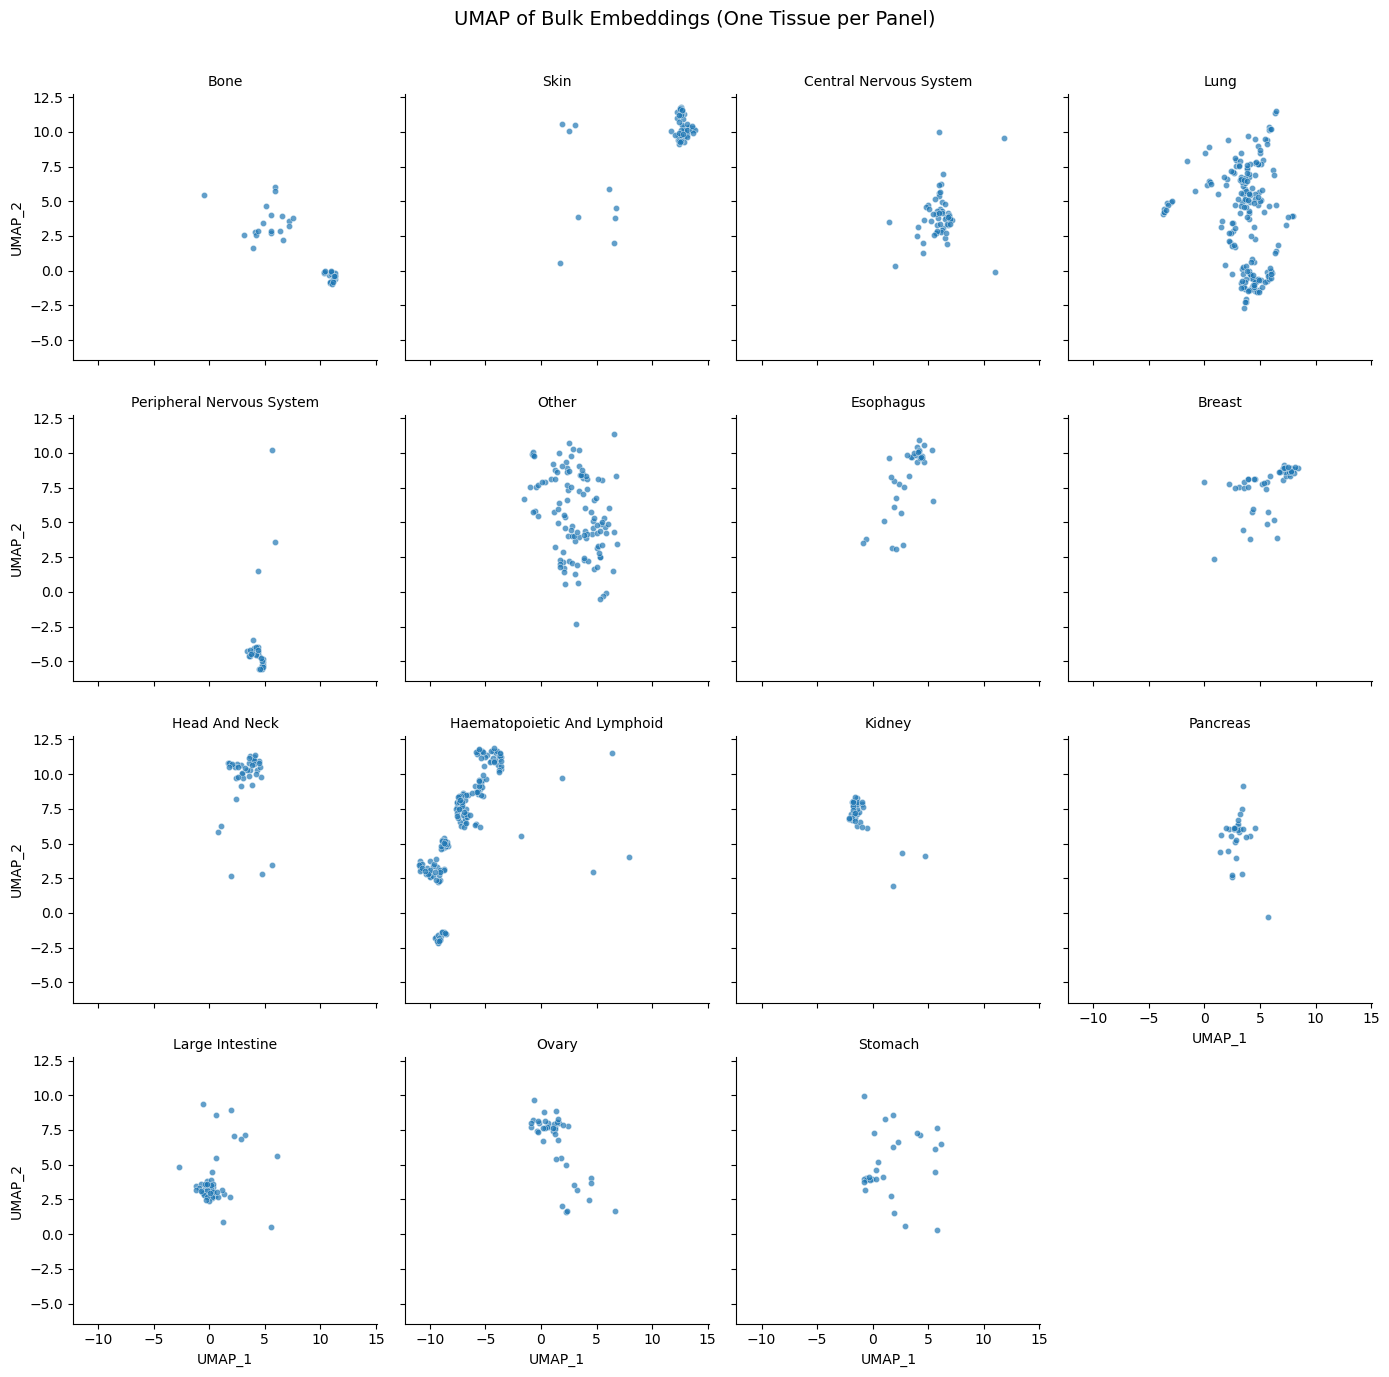

In [15]:
import umap

# Apply UMAP on scaled PCA features
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,       # lower from 15 to 5
    min_dist=0.5,        # increase from 0.1 to 0.5
    random_state=42
)
X_umap = umap_reducer.fit_transform(X_scaled)

df_unique.loc[:, "UMAP_1"] = X_umap[:, 0]
df_unique.loc[:, "UMAP_2"] = X_umap[:, 1]


# Plot UMAP colored by tissue
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_unique,
    x="UMAP_1",
    y="UMAP_2",
    hue="Tissue",
    s=30,
    alpha=0.8,
    palette="tab10"
)
plt.title("UMAP of scFoundation PCs Colored by Tissue")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Faceted UMAP per tissue for detailed exploration
g = sns.FacetGrid(df_unique, col="Tissue", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="UMAP_1", y="UMAP_2", s=20, alpha=0.7)
g.set_titles(col_template="{col_name}", size=10)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("UMAP of Bulk Embeddings (One Tissue per Panel)", fontsize=14)
plt.show()


In [11]:
# Count per tissue
cell_lines_per_tissue = df_unique.groupby("Tissue")["SANGER_MODEL_ID"].nunique().sort_values(ascending=False)

# Total count
total_cell_lines = df_unique["SANGER_MODEL_ID"].nunique()

# Display
print("📊 Number of unique cell lines per tissue:")
print(cell_lines_per_tissue)
print(f"\n🔢 Total unique cell lines: {total_cell_lines}")


📊 Number of unique cell lines per tissue:
Tissue
Lung                           191
Haematopoietic And Lymphoid    170
Other                          118
Skin                            57
Central Nervous System          55
Breast                          51
Large Intestine                 48
Head And Neck                   42
Ovary                           41
Bone                            40
Esophagus                       35
Kidney                          33
Pancreas                        31
Peripheral Nervous System       31
Stomach                         28
Name: SANGER_MODEL_ID, dtype: int64

🔢 Total unique cell lines: 971
